In [1]:
import numpy as np
class SEIR_Simulation:
    def __init__(self,m,i_n=0,dynamic=False):
        self.m=m
        self.i_n=i_n
        self.infected = [node for node, nstatus in m.status.items() if nstatus==1] 
        self.dynamic=dynamic
  
    def iterator(self,node_status=True):
        m=self.m
        m.clean_initial_status(list(m.available_statuses.values())) #make sure nodes in "s","e","i", and "r" status otherwise make it to "s"
        actual_status = {node: nstatus for node, nstatus in m.status.items()}
        m.progress_I = {node: 0 for node in actual_status if actual_status[node] == 1} # get all the infected nodes

        if m.actual_iteration == 0:
            m.actual_iteration += 1
            delta, node_count, status_delta = m.status_delta(actual_status)
            if node_status:
                return {"iteration": 0, "status": actual_status.copy(),
                        "node_count": node_count.copy(), "status_delta": status_delta.copy()}
            else:
                return {"iteration": 0, "status": {},
                        "node_count": node_count.copy(), "status_delta": status_delta.copy()}

        for u in m.graph.nodes:

            u_status = m.status[u]
            eventp = np.random.random_sample() #the event transmissble probability

            neighbors = m.graph.neighbors(u) #only consider the direct contact with distance equal to 1
            if m.graph.directed:
                neighbors = m.graph.predecessors(u)
                


            if u_status == 0:  # Susceptible

                infected_neighbors = [v for v in neighbors if m.status[v] == 1 ]
                triggered = 1 if len(infected_neighbors) > 0 else 0
                
                if self.dynamic:
                    dynamic_select=np.random.random()
                    infected_neighbors=random.choices(infected_neighbors,k=round(dynamic_select*len(infected_neighbors)))

                if m.params['model']['tp_rate'] == 1:
                    if eventp < 1 - (1 - m.params['model']['beta']) ** (len(infected_neighbors)): 
                        actual_status[u] = 2  # Exposed
                        m.progress[u] = m.actual_iteration  # save time of exposure t_i
                else:
                    if eventp < m.params['model']['beta'] * triggered:
                        actual_status[u] = 2  # Exposed
                        m.progress[u] = m.actual_iteration  # save time of exposure t_i

            elif u_status == 2:

                # apply prob. of infection, after (t - t_i) 
                if eventp < 1 - np.exp(- (m.actual_iteration - m.progress[u]) * m.params['model']['alpha']): #exponential distribution
                    actual_status[u] = 1  # Infected
                    m.progress_I[u] = m.actual_iteration
                    del m.progress[u]

            elif u_status == 1:
                if eventp < 1 - np.exp(- (m.actual_iteration - m.progress_I[u]) * m.params['model']['gamma']):
                    actual_status[u] = 3  # Recovered
                    del m.progress_I[u]

        delta, node_count, status_delta = m.status_delta(actual_status)
        m.status = actual_status
        m.actual_iteration += 1
        self.m=m

        if node_status:
            return {"iteration": m.actual_iteration - 1, "status": delta.copy(),
                    "node_count": node_count.copy(), "status_delta": status_delta.copy()}
        else:
            return {"iteration": m.actual_iteration - 1, "status": {},
                    "node_count": node_count.copy(), "status_delta": status_delta.copy()}
        
    def iterations(self,t_s=0):
        final_results=[]
        count=0
        if t_s==0:
            while True:
                update=self.iterator()
                dif_S=update["status_delta"][0]
                dif_E=update["status_delta"][2]
                dif_I=update["status_delta"][1]
                dif_R=update["status_delta"][3]
                final_results.append(update)
                if dif_S==0 and dif_I==0 and dif_E==0 and dif_R==0:
                    count+=1
                else:
                    count=0
                if count==3:
                    return final_results
        else:
            for i in range(t_s):
                update=self.iterator()
                dif_S=update["status_delta"][0]
                dif_E=update["status_delta"][2]
                dif_I=update["status_delta"][1]
                dif_R=update["status_delta"][3]
                final_results.append(update)

            return final_results
        
            #print(model.get_status_map())

    def population_plot(self,results):
        S=[]
        E=[]
        I=[]
        R=[]
        for result in results:
            S.append(result["node_count"][0])
            E.append(result["node_count"][2])
            I.append(result["node_count"][1])
            R.append(result["node_count"][3])
        plt.plot(S, label="Susceptible", color="green")
        plt.plot(E, label="Exposed", color="cyan")
        plt.plot(I, label="Infectious", color="red")
        plt.plot(R, label="Recoverd", color="blue")
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Prevalence rate",fontsize=15)
        #plt.title("prevalence for SEIR Model simulation")
        plt.legend()
        plt.show()
    
    def prevalence_plot(self,results):
        total1=len(self.m.graph.nodes)
        P_I_1=[]

        for result in results:
            P_I_1.append((result["node_count"][1]+result["node_count"][2])/total1)

        plt.plot(P_I_1, label="layer1 infected rate", color="red")

        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Prevalence rate z",fontsize=15)
        #plt.title("prevalence for SEIR Model simulation")
        plt.legend()
        plt.show()
        
    def population_plot_percentage(self,results):
        S=[]
        E=[]
        I=[]
        R=[]
        total=len(self.m.graph.nodes)
        for result in results:
            S.append(result["node_count"][0]/total)
            E.append(result["node_count"][2]/total)
            I.append(result["node_count"][1]/total)
            R.append(result["node_count"][3]/total)
        plt.plot(S, label="Susceptible", color="green")
        plt.plot(E, label="Exposed", color="cyan")
        plt.plot(I, label="Infectious", color="red")
        plt.plot(R, label="Recoverd", color="blue")
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Population fraction",fontsize=15)
        #plt.title("prevalence for SEIR Model simulation")
        plt.legend()
        plt.show()
        
        
    def population_plot_percentage_saving(self,results,save):
        S=[]
        E=[]
        I=[]
        R=[]
        total=len(self.m.graph.nodes)
        for result in results:
            S.append(result["node_count"][0]/total)
            E.append(result["node_count"][2]/total)
            I.append(result["node_count"][1]/total)
            R.append(result["node_count"][3]/total)
            
        fig, ax = plt.subplots(figsize=(8,6))
        plt.plot(S, label="Susceptible", color="green")
        plt.plot(E, label="Exposed", color="cyan")
        plt.plot(I, label="Infectious", color="red")
        plt.plot(R, label="Recoverd", color="blue")
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Population fraction",fontsize=15)
        #plt.title("prevalence for SEIR Model simulation")
        plt.legend()
        
        image_format = 'eps' # e.g .png, .svg, etc.


        fig.savefig(save, format=image_format, dpi=1200)   


        plt.show()
        
       
        
        
        
    def cum_cost(self,results):
        total_infect=len(self.infected)
        infected=len(self.infected)
        infect_changes=[]
        infect_nodes=[]
        cost=0
        t_cost=[]
        # objective function:
        def obj(infected):
            return (10*self.i_n+100*infected)
        for i in results:
            changes=i["status_delta"][1]
            infect_changes.append(changes)
            infected=(i["node_count"][1])
            cost+=obj(infected)
            if changes>0:
                total_infect+=changes 

            t_cost.append(cost)
            infect_nodes.append(total_infect)
        return t_cost, infect_nodes  
    
    def cum_cost_plot(self,results):
        t_cost, cul_infect_nodes= self.cum_cost(results)   

        #plt.plot(cul_infect_nodes,label="cumulated infected individuals")
        plt.plot(t_cost,label="total cost along with time steps")
        plt.xlabel("time steps")
        plt.ylabel("cost") 
        plt.title("Cumulated cost for SEIR Model simulation")
        plt.legend()
        plt.show()
        
    def daily_cost(self,results):
        total_infect=len(self.infected)
        infected=len(self.infected)
        infect_nodes=[]
        infect_changes=[]
        costs=[]
        # objective function:
        def obj(infected):
            return (10*self.i_n+100*infected)
        for i in results:
            changes=i["status_delta"][1]
            infect_changes.append(changes)
            infected=(i["node_count"][1])
            cost=obj(infected)
            costs.append(cost)
            infect_nodes.append(infected)

        return costs, infect_nodes 
    def daily_cost_plot(self,results):
        cost, infect_nodes= self.daily_cost(results)   
        #plt.plot(infect_nodes,label="infected individuals")
        plt.plot(cost,label="cost along with time steps")
        plt.xlabel("time steps")
        plt.ylabel("cost")
        plt.title("daily cost for SEIR Model simulation")
        plt.legend()
        plt.show()

In [2]:
import numpy as np
import future
import matplotlib.pyplot as plt
import random
from math import comb
import pandas as pd
from tqdm import tqdm
import math
class SEIR_influence_Simulation:
    def __init__(self,G_c1,G_c2,G_i,immediate_cost=0.1,accumulate_factor=0.9,order=3,comply=15,cost_scaling=3,
                 scaling_fator=3,cautious_population=2,imitation_rate=0.1,rational_rate=9,policy=None,lock_time=10,p_c1=0,
                 p_c2=0,dynamic=False):
        G_i.protection = {node: [0.00] for node in G_i.graph.nodes}
        self.simplexes = {node: [0.00] for node in G_i.graph.nodes}
        self.G_i=G_i
        self.G_c1=G_c1
        self.G_c2=G_c2
        self.dynamic=dynamic
        #self.protection_effectness=protection_effectness
        self.immediate_cost=immediate_cost
        self.accumulate_factor=accumulate_factor
        self.scaling_fator=scaling_fator
        self.cautious_population=cautious_population
        self.rational_rate=rational_rate
        self.policy=policy
        self.G_c1.constant=0
        self.G_c2.constant=0
        self.order=order
        self.comply=comply
        self.cost_scaling=cost_scaling
        self.lock_time=lock_time
        self.G_c1.p_s=p_c1 #policy starting time
        self.G_c2.p_s=p_c2
        self.G_c1.npp=[] #recording the policy
        self.G_c2.npp=[]
        self.G_c1.risky=[]        
        self.G_c2.risky=[]             
        self.G_c1.prevalence_rate=[]        
        self.G_c2.prevalence_rate=[]  
        self.imitation=imitation_rate
        
# 0 is  Susceptible, 1 is infected, 2 is exposed, 3 is recovered


               
    def non_pharmacy_policy(self,C_L):
        policy=self.policy
        if policy==None:
            return 0.0
        else:
            t=self.lock_time
            if C_L.actual_iteration>=t:
                p=np.mean(C_L.prevalence_rate[-t:-1])
            else:
                p=np.mean(C_L.prevalence_rate)
            return policy(p)

    def cost_i(self,node_i):      #cost for taking different protective behaviour
        def maxi(x):              # the protective behaviour great than 0.2 will cause cost
            if x-0.2>0:
                return x-0.2
            else:
                return 0
        c=self.immediate_cost
        t=self.G_i.actual_iteration
        accumulate_factor=self.accumulate_factor
        cost=c
        for t_step,prot in enumerate(self.G_i.protection[node_i]):     # Σ(accumulate_factor^(t-s))*maxi(prot(s))
                cost+=(accumulate_factor**(t-t_step))*self.cost_scaling*maxi(prot)   
        return cost

    def risky_p(self,C_L):       #contact layer risk perception based on prevalence
        k=self.scaling_fator
        alpha=self.cautious_population
        c=C_L
        p=self.prevalence(c)
        return k*p**alpha

    def prevalence(self,C_L):            #contact layer prevalence
        num_infected=np.sum([i for i in C_L.status.values() if i==1 or i==2]) 
        return num_infected/len(C_L.status.values())
    


    
    
    def complexes_protection(self,node):  #match the neighbors protective behaviour
        order=self.order
        if node in self.G_c1.graph.nodes and node not in self.G_c2.graph.nodes:
            layer=self.G_c1
        elif node in self.G_c2.graph.nodes and node not in self.G_c1.graph.nodes:
            layer=self.G_c2
        else:
            layer=self.G_c2
           
        T=layer.actual_iteration
        
        neighbors=self.G_i.graph.neighbors(node)
        #protect_influence=[self.G_i.protection[i][-1] for i in neighbors] #get all the pairwise interaction information
        protect_influence=[self.G_i.protection[i][T-1] for i in neighbors] #get all the pairwise interaction information
        total=len(neighbors)
        vertices=[i for i in range(1,order+1)]
        complexes=[]
        comp_co=[] #the coefficient for different order complex
        comp_l=[] #record the order of each complex
        while len(neighbors)>0:  #select different number of nodes to constitute multiple simplexes
            if len(neighbors)>=order:
                num_vertice=random.choice(vertices)
            else:
                num_vertice=random.choice(range(1,len(neighbors)+1))
            nodes=random.sample(neighbors,k=num_vertice)
            neighbors=list(set(neighbors)-set(nodes))
            complexes.append(nodes)
            comp_l.append(len(nodes))
   
        comp_co=[((1+comp_l.count(i)/len(comp_l))**(comb(i+1,3))) for i in comp_l]

        for ind in range(len(complexes)):
            comp=complexes[ind]
            coefficient=comp_co[ind]
            complex_effectness=[]
            if coefficient>1: #get collective interactions
                for node in comp:
                    complex_effectness.append(self.G_i.protection[node][-1])
                    
                protect_influence.append(np.mean(complex_effectness)*coefficient)
  

        final_protection=sum(protect_influence)/total
        
        return final_protection
    
    def LayerP(self,layer):
        layer.te=layer.actual_iteration
        if layer.te>=layer.p_s:   #current time greater the policy start time will execute policy
            if layer.constant==0:  #executed policy activating
                np_p=self.non_pharmacy_policy(layer)
                layer.constant=1
                layer.ts=layer.actual_iteration # policy activating time
            elif layer.te-layer.ts==self.lock_time-1:  # policy executing time counting
                layer.constant=0
                np_p=layer.npp[-1]
            else:
                np_p=layer.npp[-1]
        else:
            np_p=0         
        return np_p
        
    



    def self_protection(self,node_i):        # this function is to calculate the final protection effectiveness

        if node_i in self.G_c1.graph.nodes and node_i not in self.G_c2.graph.nodes:
            layer=self.G_c1
        elif node_i in self.G_c2.graph.nodes and node_i not in self.G_c1.graph.nodes:
            layer=self.G_c2
        else:
            layer=self.G_c2
           
        layer.te=layer.actual_iteration

        risky=layer.risky[-1]


        fatigure=np.exp(-layer.te/self.comply)
        rational_rate=self.rational_rate
        npp=fatigure*layer.npp[-1]
        imitation=self.imitation*self.complexes_protection(node_i)

        pi_0_t=-imitation+self.cost_i(node_i)
        pi_1_t=imitation+risky+npp
        #p_p=1-np.exp(rational_rate*pi_0_t)/(np.exp(rational_rate*pi_1_t)+np.exp(rational_rate*pi_0_t))
        def sigmoid(x,r):
            z = np.exp(-r*x)

            sig = (2 / (1 + z))-1
            return sig
        d=pi_1_t-pi_0_t

        return sigmoid(d,rational_rate)
    
    
  
    def iterator(self,node_status=True):

        G_c1=self.G_c1
        G_c2=self.G_c2
        G_i=self.G_i
        G_c1.clean_initial_status(list(G_c1.available_statuses.values())) #make sure nodes in "s","e","i", and "r" status otherwise make it to "s"
        G_c1_actual_status = {node: ns for node, ns in G_c1.status.items()}
        G_c2_actual_status = {node: ns for node, ns in G_c2.status.items()}
        #G_i_protection_delta = {node: 0.05 for node in G_i.graph.nodes}
        influence_actual_status = {node: ns for node, ns in G_i.status.items()}
        G_c1.progress_I = {node: 0 for node in G_c1_actual_status if G_c1_actual_status[node] == 1} # get all the infected nodes
        G_c2.progress_I = {node: 0 for node in G_c2_actual_status if G_c2_actual_status[node] == 1} # get all the infected nodes


        prevalence1=self.prevalence(self.G_c1)#calculate the prevalence reate
        prevalence2=self.prevalence(self.G_c2)
        self.G_c1.prevalence_rate.append(prevalence1)#upate the prevalence reate
        self.G_c2.prevalence_rate.append(prevalence2)
        risky1=self.risky_p(self.G_c1)#calculate the risky
        risky2=self.risky_p(self.G_c2)
        self.G_c1.risky.append(risky1)#upate the risky
        self.G_c2.risky.append(risky2)
        policy1=self.LayerP(self.G_c1)#calculate the policy
        policy2=self.LayerP(self.G_c2)
        self.G_c1.npp.append(policy1)#upate the policy
        self.G_c2.npp.append(policy2) 
        simplexes=self.simplexes
        
        if G_c1.actual_iteration == 0:          
            nodes=[node for node in G_c1.graph.nodes if node in G_c2.graph.nodes] #update the same nodes
            for i in nodes:
                G_c2_actual_status[i] = G_c1_actual_status[i]

                G_c2.status=G_c2_actual_status
                G_c2.progress_I = {node: 0 for node in G_c2_actual_status if G_c2_actual_status[node] == 1} # get all the infected nodes
            G_c1.actual_iteration += 1
            G_c2.actual_iteration += 1
            
            delta_1, node_count_1, status_delta_1 = G_c1.status_delta(G_c1_actual_status)
            delta_2, node_count_2, status_delta_2 = G_c2.status_delta(G_c2_actual_status)

            if node_status:
                return [{"iteration": 0, "status_1": G_c1_actual_status.copy(),
                        "node_count_1": node_count_1.copy(), "status_delta_1": status_delta_1.copy()},
                       {"iteration": 0, "status_2": G_c2_actual_status.copy(),
                        "node_count_2": node_count_2.copy(), "status_delta_2": status_delta_2.copy()}]
            else:
                return {"iteration": 0, "status": {},
                        "node_count": node_count.copy(), "status_delta": status_delta.copy()}
        #print(f"this is the {G_c.actual_iteration} time step",self.prevelance())
        for nd in G_i.graph.nodes:
            eventp = np.random.random_sample() #the event transmissble probability
            if nd in G_c1.graph.nodes and nd not in G_c2.graph.nodes:
                nd_status = G_c1.status[nd]
                neighbors = G_c1.graph.neighbors(nd) #only consider the direct contact with distance equal to 1
                infected_neighbors = [v for v in neighbors if G_c1.status[v] == 1]
                layer=1
            elif nd in G_c2.graph.nodes and nd not in G_c1.graph.nodes:
                nd_status = G_c2.status[nd]
                neighbors = G_c2.graph.neighbors(nd) #only consider the direct contact with distance equal to 1
                infected_neighbors = [v for v in neighbors if G_c2.status[v] == 1]
                layer=2
            elif nd in G_c2.graph.nodes and nd in G_c1.graph.nodes:
                nd_status = G_c1.status[nd]
                neighbors1 = G_c1.graph.neighbors(nd) #only consider the direct contact with distance equal to 1
                neighbors2 = G_c2.graph.neighbors(nd)
                infected_neighbors1 = [v for v in neighbors1 if G_c1.status[v] == 1]
                infected_neighbors2 = [v for v in neighbors2 if G_c2.status[v] == 1]
                infected_neighbors=list(set(infected_neighbors1+infected_neighbors2))
                layer=3
            else:
                print("issues")
                
            if self.dynamic:
                dynamic_select=np.random.random()
                infected_neighbors=random.choices(infected_neighbors,k=round(dynamic_select*len(infected_neighbors)))
            
            if nd_status == 0:  # Susceptible

                    simplexes[nd].append(self.complexes_protection(nd))

                    triggered = 1 if len(infected_neighbors) > 0 else 0

                    if G_c1.params['model']['tp_rate'] == 1:
                        protection=self.self_protection(nd)
                        G_i.protection[nd].append(protection)



                        if eventp < ((1-protection)/2)*(1 - ((1 - G_c1.params['model']['beta']) ** len(infected_neighbors))): 
                            if layer==1: 
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration  # save time of exposure t_i
                            elif layer==2: 
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed
                            else:
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed

                    else:
                        if eventp < G_c1.params['model']['beta'] * triggered:
                            if layer==1: 
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration  # save time of exposure t_i
                            elif layer==2: 
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed
                            else:
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed


            elif nd_status == 2: #exposed
                simplexes[nd].append(0.00)
                protection=self.self_protection(nd)
                G_i.protection[nd].append(protection)
                #G_i.protection[nd].append(0.00)
                # apply prob. of infection, after (t - t_i) 

                if layer==1:
                    if eventp < 1 - np.exp(- (G_c1.actual_iteration - G_c1.progress[nd]) * G_c1.params['model']['alpha']): #exponential distribution
                        G_c1_actual_status[nd] = 1  # Infected 
                        G_c1.progress_I[nd] = G_c1.actual_iteration  # save time of # Infected t_i
                        del G_c1.progress[nd]
                elif layer==2:
                    if eventp < 1 - np.exp(- (G_c2.actual_iteration - G_c2.progress[nd]) * G_c2.params['model']['alpha']): #exponential distribution
                        G_c2.progress_I[nd] = G_c2.actual_iteration
                        G_c2_actual_status[nd] = 1  # Infected
                        del G_c2.progress[nd]
                else:
                   
                    if eventp < 1 - np.exp(- (G_c1.actual_iteration - G_c1.progress[nd]) * G_c1.params['model']['alpha']): #exponential distribution
                        G_c1_actual_status[nd] = 1  # Infected
                        G_c1.progress_I[nd] = G_c1.actual_iteration
                        G_c2.progress_I[nd] = G_c2.actual_iteration
                        G_c2_actual_status[nd] = 1  
                        del G_c2.progress[nd]
                        del G_c1.progress[nd]




            elif nd_status == 1:
                #G_i.protection[nd].append(0.00)
                simplexes[nd].append(0.00)
                protection=self.self_protection(nd)
                G_i.protection[nd].append(protection)
                if layer==1:

                    if eventp < 1 - np.exp(- (G_c1.actual_iteration - G_c1.progress_I[nd]) * G_c1.params['model']['gamma']):
                        G_c1_actual_status[nd] = 3  # Recovered
                        del G_c1.progress_I[nd]

                elif layer==2:
                    if eventp < 1 - np.exp(- (G_c2.actual_iteration - G_c2.progress_I[nd]) * G_c2.params['model']['gamma']):
                        G_c2_actual_status[nd] = 3  # Recovered
                        del G_c2.progress_I[nd]
                else:
                    if eventp < 1 - np.exp(- (G_c2.actual_iteration - G_c2.progress_I[nd]) * G_c2.params['model']['gamma']):
                        G_c2_actual_status[nd] = 3  # Recovered
                        del G_c2.progress_I[nd]
                        G_c1_actual_status[nd] = 3  # Recovered
                        del G_c1.progress_I[nd]
            else:
                protection=self.self_protection(nd)
                G_i.protection[nd].append(protection)
                simplexes[nd].append(0.00)
                
                            
        delta_1, node_count_1, status_delta_1 = G_c1.status_delta(G_c1_actual_status)
        delta_2, node_count_2, status_delta_2 = G_c2.status_delta(G_c2_actual_status) #delta is the changed node and its value


 
        G_c1.status = G_c1_actual_status
        G_c2.status = G_c2_actual_status

        G_c1.actual_iteration += 1
        G_c2.actual_iteration += 1
        
        G_i.actual_iteration += 1
        self.G_c1=G_c1
        self.G_c2=G_c2
        self.G_i=G_i
        self.simplexes=simplexes

        if node_status:
            return [{"iteration": G_c1.actual_iteration-1, "status_1": G_c1_actual_status.copy(),
                    "node_count_1": node_count_1.copy(), "status_delta_1": status_delta_1.copy()},
                    {"iteration": G_c2.actual_iteration-1, "status_2": G_c2_actual_status.copy(),
                    "node_count_2": node_count_2.copy(), "status_delta_2": status_delta_2.copy()}] 
        
        
        
        
    def iterations(self,t_s=0):
        final_results=[]
        count=0
        if t_s==0:
            while True:
                update=self.iterator()
                dif_S=update["status_delta_1"][0]
                dif_E=update["status_delta_1"][2]
                dif_I=update["status_delta_1"][1]
                dif_R=update["status_delta_1"][3]
                final_results.append(update)
                if dif_S==0 and dif_I==0 and dif_E==0 and dif_R==0:
                    count+=1
                else:
                    count=0
                if count==3:
                    return final_results
        else:
            for i in tqdm(range(t_s)):
                update=self.iterator()
                dif_S=update[0]["status_delta_1"][0]
                dif_E=update[0]["status_delta_1"][2]
                dif_I=update[0]["status_delta_1"][1]
                dif_R=update[0]["status_delta_1"][3]
                final_results.append(update)

            return final_results
        
            #print(model.get_status_map())

    def prevalence_plot(self,results):
        total1=len(self.G_c1.graph.nodes)
        total2=len(self.G_c2.graph.nodes)
        P_I_1=[]
        P_I_2=[]
        for result in results:
            P_I_1.append((result[0]["node_count_1"][1]+result[0]["node_count_1"][2])/total1)
            P_I_2.append((result[1]["node_count_2"][1]+result[1]["node_count_2"][2])/total2)
        plt.plot(P_I_1, label="Community A", color="red")
        plt.plot(P_I_2, label="Community B", color="black")
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Prevalence rate z",fontsize=15)
        #plt.title("prevalence for SEIR Model simulation")
        plt.legend()
        plt.show()
    
    def population_plot(self,results):
        S1=[]
        E1=[]
        I1=[]
        R1=[]
        S2=[]
        E2=[]
        I2=[]
        R2=[]
        for result in results:
            S1.append(result[0]["node_count_1"][0])
            E1.append(result[0]["node_count_1"][2])
            I1.append(result[0]["node_count_1"][1])
            R1.append(result[0]["node_count_1"][3])
            S2.append(result[1]["node_count_2"][0])
            E2.append(result[1]["node_count_2"][2])
            I2.append(result[1]["node_count_2"][1])
            R2.append(result[1]["node_count_2"][3])            
        plt.plot(S1, label="Susceptible", color="green")
        plt.plot(E1, label="Exposed", color="cyan")
        plt.plot(I1, label="Infectious", color="red")
        plt.plot(R1, label="Recoverd", color="blue")
        plt.xlabel("time steps")
        plt.ylabel("population")
        plt.title("Layer 1 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show()
        

        plt.plot(S2, label="Susceptible", color="green")
        plt.plot(E2, label="Exposed", color="cyan")
        plt.plot(I2, label="Infectious", color="red")
        plt.plot(R2, label="Recoverd", color="blue")
        plt.xlabel("time steps")
        plt.ylabel("population")
        plt.title("Layer 2 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show() 
        
    def saving_result(self,results,name="without_influence_overall_results"):
        total1=len(self.G_c1.graph.nodes)
        total2=len(self.G_c2.graph.nodes)
        Pr1=[]
        Pr2=[]
        Status_1=[]
        Status_2=[]
        node_count_1=[]
        node_count_2=[]
        status_delta_1=[]
        status_delta_2=[]
        columns=[]
        ites=[]
        for result in results:
            Pr1.append((result[0]["node_count_1"][1]+result[0]["node_count_1"][2])/total1)
            Pr2.append((result[1]["node_count_2"][1]+result[1]["node_count_2"][2])/total2)
            Status_1.append(result[0]["status_1"])
            Status_2.append(result[1]["status_2"])
            node_count_1.append(result[0]["node_count_1"])
            node_count_2.append(result[1]["node_count_2"])
            status_delta_1.append(result[0]["status_delta_1"])
            status_delta_2.append(result[1]["status_delta_2"])
            ites.append(result[0]["iteration"])
        res={"iteration":ites,"status_1":Status_1,"node_count_1":node_count_1,"status_delta_1":status_delta_1,"prevalence_rate_1":Pr1,
            "status_2":Status_2,"node_count_2":node_count_2,"status_delta_2":status_delta_2,"prevalence_rate_2":Pr2}
        df=pd.DataFrame(data=res)
        df.to_csv(f".//result//{name}.csv")
        
    def population_plot_percentage(self,results):
        S1=[]
        E1=[]
        I1=[]
        R1=[]
        S2=[]
        E2=[]
        I2=[]
        R2=[]
        total_1=len(self.G_c1.graph.nodes)
        total_2=len(self.G_c2.graph.nodes)
        for result in results:
            S1.append(result[0]["node_count_1"][0]/total_1)
            E1.append(result[0]["node_count_1"][2]/total_1)
            I1.append(result[0]["node_count_1"][1]/total_1)
            R1.append(result[0]["node_count_1"][3]/total_1)
            S2.append(result[1]["node_count_2"][0]/total_2)
            E2.append(result[1]["node_count_2"][2]/total_2)
            I2.append(result[1]["node_count_2"][1]/total_2)
            R2.append(result[1]["node_count_2"][3]/total_2)            
        plt.plot(S1, label="Susceptible", color="green")
        plt.plot(E1, label="Exposed", color="cyan")
        plt.plot(I1, label="Infectious", color="red")
        plt.plot(R1, label="Recoverd", color="blue")
        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Population fraction",fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15) 
        #plt.title("Layer 1 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show()
        
        plt.plot(S2, label="Susceptible", color="green")
        plt.plot(E2, label="Exposed", color="cyan")
        plt.plot(I2, label="Infectious", color="red")
        plt.plot(R2, label="Recoverd", color="blue")
        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Population fraction",fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15) 
        #plt.title("Layer 2 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show()
        
    

In [3]:
import numpy as np
import future
import matplotlib.pyplot as plt
import random
from math import comb
import pandas as pd
from tqdm import tqdm
import math
class SEIR_influence_control_Simulation:
    def __init__(self,G_c1,G_c2,G_i,immediate_cost=0.1,accumulate_factor=0.9,order=3,comply=15,cost_scaling=3,
                 scaling_fator=3,cautious_population=2,imitation_rate=0.3,rational_rate=9,policy=None,lock_time=10,p_c1=0,
                 p_c2=0,dynamic=False,control_1=True,control_2=True,control_p=0):
        G_i.protection = {node: [0.00] for node in G_i.graph.nodes}
        self.simplexes = {node: [0.00] for node in G_i.graph.nodes}
        self.G_i=G_i
        self.G_c1=G_c1
        self.G_c2=G_c2
        self.dynamic=dynamic
        #self.protection_effectness=protection_effectness
        self.immediate_cost=immediate_cost
        self.accumulate_factor=accumulate_factor
        self.scaling_fator=scaling_fator
        self.cautious_population=cautious_population
        self.rational_rate=rational_rate
        self.policy=policy
        self.G_c1.constant=0
        self.G_c2.constant=0
        self.order=order
        self.comply=comply
        self.cost_scaling=cost_scaling
        self.lock_time=lock_time
        self.G_c1.p_s=p_c1 #policy starting time
        self.G_c2.p_s=p_c2
        self.G_c1.control=control_1 #control policy
        self.G_c2.control=control_2
        self.G_c1.npp=[] #recording the policy
        self.G_c2.npp=[]
        self.G_c1.risky=[]        
        self.G_c2.risky=[]             
        self.G_c1.prevalence_rate=[]        
        self.G_c2.prevalence_rate=[]  
        self.control_p=control_p
        self.imitation=imitation_rate
        
# 0 is  Susceptible, 1 is infected, 2 is exposed, 3 is recovered


               
    def non_pharmacy_policy(self,C_L):
        policy=self.policy
        if policy==None:
            return 0.0
        else:
            t=self.lock_time
            if C_L.actual_iteration>=t:
                p=np.mean(C_L.prevalence_rate[-t:-1])
            else:
                p=np.mean(C_L.prevalence_rate)
            return policy(p)

    def cost_i(self,node_i):      #cost for taking different protective behaviour
        def maxi(x):              # the protective behaviour great than 0.2 will cause cost
            if x-0.2>0:
                return x-0.2
            else:
                return 0
        c=self.immediate_cost
        t=self.G_i.actual_iteration
        accumulate_factor=self.accumulate_factor
        cost=c
        for t_step,prot in enumerate(self.G_i.protection[node_i]):     # Σ(accumulate_factor^(t-s))*maxi(prot(s))
                cost+=(accumulate_factor**(t-t_step))*self.cost_scaling*maxi(prot)   
        return cost

    def risky_p(self,C_L):       #contact layer risk perception based on prevalence
        k=self.scaling_fator
        alpha=self.cautious_population
        c=C_L
        p=self.prevalence(c)
        return k*p**alpha

    def prevalence(self,C_L):            #contact layer prevalence
        num_infected=np.sum([i for i in C_L.status.values() if i==1 or i==2]) 
        return num_infected/len(C_L.status.values())
    


    
    
    def complexes_protection(self,node):  #match the neighbors protective behaviour
        order=self.order
        if node in self.G_c1.graph.nodes and node not in self.G_c2.graph.nodes:
            layer=self.G_c1
        elif node in self.G_c2.graph.nodes and node not in self.G_c1.graph.nodes:
            layer=self.G_c2
        else:
            layer=self.G_c2
           
        T=layer.actual_iteration
        
        neighbors=self.G_i.graph.neighbors(node)
        #protect_influence=[self.G_i.protection[i][-1] for i in neighbors] #get all the pairwise interaction information
        protect_influence=[self.G_i.protection[i][T-1] for i in neighbors] #get all the pairwise interaction information
        total=len(neighbors)
        vertices=[i for i in range(1,order+1)]
        complexes=[]
        comp_co=[] #the coefficient for different order complex
        comp_l=[] #record the order of each complex
        while len(neighbors)>0:  #select different number of nodes to constitute multiple simplexes
            if len(neighbors)>=order:
                num_vertice=random.choice(vertices)
            else:
                num_vertice=random.choice(range(1,len(neighbors)+1))
            nodes=random.sample(neighbors,k=num_vertice)
            neighbors=list(set(neighbors)-set(nodes))
            complexes.append(nodes)
            comp_l.append(len(nodes))
   
        comp_co=[((1+comp_l.count(i)/len(comp_l))**(comb(i+1,3))) for i in comp_l]

        for ind in range(len(complexes)):
            comp=complexes[ind]
            coefficient=comp_co[ind]
            complex_effectness=[]
            if coefficient>1: #get collective interactions
                for node in comp:
                    complex_effectness.append(self.G_i.protection[node][-1])
                    
                protect_influence.append(np.mean(complex_effectness)*coefficient)
  

        final_protection=sum(protect_influence)/total
        
        return final_protection
    
    def LayerP(self,layer):
        layer.te=layer.actual_iteration
        if layer.te>=layer.p_s:   #current time greater the policy start time will execute policy
            if layer.constant==0:  #executed policy activating
                np_p=self.non_pharmacy_policy(layer)
                layer.constant=1
                layer.ts=layer.actual_iteration # policy activating time
            elif layer.te-layer.ts==self.lock_time-1:  # policy executing time counting
                layer.constant=0
                np_p=layer.npp[-1]
            else:
                np_p=layer.npp[-1]
        else:
            np_p=0         
        return np_p

        
    



    def self_protection(self,node_i):        # this function is to calculate the final protection effectiveness

        if node_i in self.G_c1.graph.nodes and node_i not in self.G_c2.graph.nodes:
            layer=self.G_c1
        elif node_i in self.G_c2.graph.nodes and node_i not in self.G_c1.graph.nodes:
            layer=self.G_c2
        else:
            layer=self.G_c2
        layer.te=layer.actual_iteration
        risky=layer.risky[-1]
        rational_rate=self.rational_rate
        if layer.control==True:
            npp=self.control_p
        else:
            fatigure=np.exp(-layer.te/self.comply)
            npp=fatigure*layer.npp[-1]


        imitation=self.imitation*self.complexes_protection(node_i)

        pi_0_t=-imitation+self.cost_i(node_i)
        pi_1_t=imitation+risky+npp
        #p_p=1-np.exp(rational_rate*pi_0_t)/(np.exp(rational_rate*pi_1_t)+np.exp(rational_rate*pi_0_t))
        def sigmoid(x,r):
            z = np.exp(-r*x)

            sig = (2 / (1 + z))-1
            return sig
        d=pi_1_t-pi_0_t

        return sigmoid(d,rational_rate)
    
    
  
    def iterator(self,node_status=True):

        G_c1=self.G_c1
        G_c2=self.G_c2
        G_i=self.G_i
        G_c1.clean_initial_status(list(G_c1.available_statuses.values())) #make sure nodes in "s","e","i", and "r" status otherwise make it to "s"
        G_c1_actual_status = {node: ns for node, ns in G_c1.status.items()}
        G_c2_actual_status = {node: ns for node, ns in G_c2.status.items()}
        #G_i_protection_delta = {node: 0.05 for node in G_i.graph.nodes}
        influence_actual_status = {node: ns for node, ns in G_i.status.items()}
        G_c1.progress_I = {node: 0 for node in G_c1_actual_status if G_c1_actual_status[node] == 1} # get all the infected nodes
        G_c2.progress_I = {node: 0 for node in G_c2_actual_status if G_c2_actual_status[node] == 1} # get all the infected nodes


        prevalence1=self.prevalence(self.G_c1)#calculate the prevalence reate
        prevalence2=self.prevalence(self.G_c2)
        self.G_c1.prevalence_rate.append(prevalence1)#upate the prevalence reate
        self.G_c2.prevalence_rate.append(prevalence2)
        risky1=self.risky_p(self.G_c1)#calculate the risky
        risky2=self.risky_p(self.G_c2)
        self.G_c1.risky.append(risky1)#upate the risky
        self.G_c2.risky.append(risky2)
        policy1=self.LayerP(self.G_c1)#calculate the policy
        policy2=self.LayerP(self.G_c2)
        self.G_c1.npp.append(policy1)#upate the policy
        self.G_c2.npp.append(policy2) 
        simplexes=self.simplexes
        
        if G_c1.actual_iteration == 0:          
            nodes=[node for node in G_c1.graph.nodes if node in G_c2.graph.nodes] #update the same nodes
            for i in nodes:
                G_c2_actual_status[i] = G_c1_actual_status[i]

                G_c2.status=G_c2_actual_status
                G_c2.progress_I = {node: 0 for node in G_c2_actual_status if G_c2_actual_status[node] == 1} # get all the infected nodes
            G_c1.actual_iteration += 1
            G_c2.actual_iteration += 1
            
            delta_1, node_count_1, status_delta_1 = G_c1.status_delta(G_c1_actual_status)
            delta_2, node_count_2, status_delta_2 = G_c2.status_delta(G_c2_actual_status)

            if node_status:
                return [{"iteration": 0, "status_1": G_c1_actual_status.copy(),
                        "node_count_1": node_count_1.copy(), "status_delta_1": status_delta_1.copy()},
                       {"iteration": 0, "status_2": G_c2_actual_status.copy(),
                        "node_count_2": node_count_2.copy(), "status_delta_2": status_delta_2.copy()}]
            else:
                return {"iteration": 0, "status": {},
                        "node_count": node_count.copy(), "status_delta": status_delta.copy()}
        #print(f"this is the {G_c.actual_iteration} time step",self.prevelance())
        for nd in G_i.graph.nodes:
            eventp = np.random.random_sample() #the event transmissble probability
            if nd in G_c1.graph.nodes and nd not in G_c2.graph.nodes:
                nd_status = G_c1.status[nd]
                neighbors = G_c1.graph.neighbors(nd) #only consider the direct contact with distance equal to 1
                infected_neighbors = [v for v in neighbors if G_c1.status[v] == 1]
                layer=1
            elif nd in G_c2.graph.nodes and nd not in G_c1.graph.nodes:
                nd_status = G_c2.status[nd]
                neighbors = G_c2.graph.neighbors(nd) #only consider the direct contact with distance equal to 1
                infected_neighbors = [v for v in neighbors if G_c2.status[v] == 1]
                layer=2
            elif nd in G_c2.graph.nodes and nd in G_c1.graph.nodes:
                nd_status = G_c1.status[nd]
                neighbors1 = G_c1.graph.neighbors(nd) #only consider the direct contact with distance equal to 1
                neighbors2 = G_c2.graph.neighbors(nd)
                infected_neighbors1 = [v for v in neighbors1 if G_c1.status[v] == 1]
                infected_neighbors2 = [v for v in neighbors2 if G_c2.status[v] == 1]
                infected_neighbors=list(set(infected_neighbors1+infected_neighbors2))
                layer=3
            else:
                print("issues")
                
            if self.dynamic:
                dynamic_select=np.random.random()
                infected_neighbors=random.choices(infected_neighbors,k=round(dynamic_select*len(infected_neighbors)))
            
            if nd_status == 0:  # Susceptible

                    simplexes[nd].append(self.complexes_protection(nd))

                    triggered = 1 if len(infected_neighbors) > 0 else 0

                    if G_c1.params['model']['tp_rate'] == 1:
                        protection=self.self_protection(nd)
                        G_i.protection[nd].append(protection)



                        if eventp < ((1-protection)/2)*(1 - ((1 - G_c1.params['model']['beta']) ** len(infected_neighbors))): 
                            if layer==1: 
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration  # save time of exposure t_i
                            elif layer==2: 
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed
                            else:
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed

                    else:
                        if eventp < G_c1.params['model']['beta'] * triggered:
                            if layer==1: 
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration  # save time of exposure t_i
                            elif layer==2: 
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed
                            else:
                                G_c1_actual_status[nd] = 2  # Exposed
                                G_c1.progress[nd] = G_c1.actual_iteration
                                G_c2.progress[nd] = G_c2.actual_iteration
                                G_c2_actual_status[nd] = 2  # Exposed


            elif nd_status == 2: #exposed
                simplexes[nd].append(0.00)
                protection=self.self_protection(nd)
                G_i.protection[nd].append(protection)
                # apply prob. of infection, after (t - t_i) 

                if layer==1:
                    if eventp < 1 - np.exp(- (G_c1.actual_iteration - G_c1.progress[nd]) * G_c1.params['model']['alpha']): #exponential distribution
                        G_c1_actual_status[nd] = 1  # Infected 
                        G_c1.progress_I[nd] = G_c1.actual_iteration  # save time of # Infected t_i
                        del G_c1.progress[nd]
                elif layer==2:
                    if eventp < 1 - np.exp(- (G_c2.actual_iteration - G_c2.progress[nd]) * G_c2.params['model']['alpha']): #exponential distribution
                        G_c2.progress_I[nd] = G_c2.actual_iteration
                        G_c2_actual_status[nd] = 1  # Infected
                        del G_c2.progress[nd]
                else:
                   
                    if eventp < 1 - np.exp(- (G_c1.actual_iteration - G_c1.progress[nd]) * G_c1.params['model']['alpha']): #exponential distribution
                        G_c1_actual_status[nd] = 1  # Infected
                        G_c1.progress_I[nd] = G_c1.actual_iteration
                        G_c2.progress_I[nd] = G_c2.actual_iteration
                        G_c2_actual_status[nd] = 1  
                        del G_c2.progress[nd]
                        del G_c1.progress[nd]




            elif nd_status == 1:

                protection=self.self_protection(nd)
                G_i.protection[nd].append(protection)
                simplexes[nd].append(0.00)
                if layer==1:

                    if eventp < 1 - np.exp(- (G_c1.actual_iteration - G_c1.progress_I[nd]) * G_c1.params['model']['gamma']):
                        G_c1_actual_status[nd] = 3  # Recovered
                        del G_c1.progress_I[nd]

                elif layer==2:
                    if eventp < 1 - np.exp(- (G_c2.actual_iteration - G_c2.progress_I[nd]) * G_c2.params['model']['gamma']):
                        G_c2_actual_status[nd] = 3  # Recovered
                        del G_c2.progress_I[nd]
                else:
                    if eventp < 1 - np.exp(- (G_c2.actual_iteration - G_c2.progress_I[nd]) * G_c2.params['model']['gamma']):
                        G_c2_actual_status[nd] = 3  # Recovered
                        del G_c2.progress_I[nd]
                        G_c1_actual_status[nd] = 3  # Recovered
                        del G_c1.progress_I[nd]
            else:
                protection=self.self_protection(nd)
                G_i.protection[nd].append(protection)
                simplexes[nd].append(0.00)
                
                            
        delta_1, node_count_1, status_delta_1 = G_c1.status_delta(G_c1_actual_status)
        delta_2, node_count_2, status_delta_2 = G_c2.status_delta(G_c2_actual_status) #delta is the changed node and its value


 
        G_c1.status = G_c1_actual_status
        G_c2.status = G_c2_actual_status

        G_c1.actual_iteration += 1
        G_c2.actual_iteration += 1
        
        G_i.actual_iteration += 1
        self.G_c1=G_c1
        self.G_c2=G_c2
        self.G_i=G_i
        self.simplexes=simplexes

        if node_status:
            return [{"iteration": G_c1.actual_iteration-1, "status_1": G_c1_actual_status.copy(),
                    "node_count_1": node_count_1.copy(), "status_delta_1": status_delta_1.copy()},
                    {"iteration": G_c2.actual_iteration-1, "status_2": G_c2_actual_status.copy(),
                    "node_count_2": node_count_2.copy(), "status_delta_2": status_delta_2.copy()}] 
        
        
        
        
    def iterations(self,t_s=0):
        final_results=[]
        count=0
        if t_s==0:
            while True:
                update=self.iterator()
                dif_S=update["status_delta_1"][0]
                dif_E=update["status_delta_1"][2]
                dif_I=update["status_delta_1"][1]
                dif_R=update["status_delta_1"][3]
                final_results.append(update)
                if dif_S==0 and dif_I==0 and dif_E==0 and dif_R==0:
                    count+=1
                else:
                    count=0
                if count==3:
                    return final_results
        else:
            for i in tqdm(range(t_s)):
                update=self.iterator()
                dif_S=update[0]["status_delta_1"][0]
                dif_E=update[0]["status_delta_1"][2]
                dif_I=update[0]["status_delta_1"][1]
                dif_R=update[0]["status_delta_1"][3]
                final_results.append(update)

            return final_results
        
            #print(model.get_status_map())

    def prevalence_plot(self,results):
        total1=len(self.G_c1.graph.nodes)
        total2=len(self.G_c2.graph.nodes)
        P_I_1=[]
        P_I_2=[]
        for result in results:
            P_I_1.append((result[0]["node_count_1"][1]+result[0]["node_count_1"][2])/total1)
            P_I_2.append((result[1]["node_count_2"][1]+result[1]["node_count_2"][2])/total2)
        plt.plot(P_I_1, label="Community A", color="red")
        plt.plot(P_I_2, label="Community B", color="black")
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Prevalence rate z",fontsize=15)
        #plt.title("prevalence for SEIR Model simulation")
        plt.legend()
        plt.show()
    
    def population_plot(self,results):
        S1=[]
        E1=[]
        I1=[]
        R1=[]
        S2=[]
        E2=[]
        I2=[]
        R2=[]
        for result in results:
            S1.append(result[0]["node_count_1"][0])
            E1.append(result[0]["node_count_1"][2])
            I1.append(result[0]["node_count_1"][1])
            R1.append(result[0]["node_count_1"][3])
            S2.append(result[1]["node_count_2"][0])
            E2.append(result[1]["node_count_2"][2])
            I2.append(result[1]["node_count_2"][1])
            R2.append(result[1]["node_count_2"][3])            
        plt.plot(S1, label="Susceptible", color="green")
        plt.plot(E1, label="Exposed", color="cyan")
        plt.plot(I1, label="Infectious", color="red")
        plt.plot(R1, label="Recoverd", color="blue")
        plt.xlabel("time steps")
        plt.ylabel("population")
        plt.title("Layer 1 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show()
        

        plt.plot(S2, label="Susceptible", color="green")
        plt.plot(E2, label="Exposed", color="cyan")
        plt.plot(I2, label="Infectious", color="red")
        plt.plot(R2, label="Recoverd", color="blue")
        plt.xlabel("time steps")
        plt.ylabel("population")
        plt.title("Layer 2 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show() 
        
    def saving_result(self,results,name="without_influence_overall_results"):
        total1=len(self.G_c1.graph.nodes)
        total2=len(self.G_c2.graph.nodes)
        Pr1=[]
        Pr2=[]
        Status_1=[]
        Status_2=[]
        node_count_1=[]
        node_count_2=[]
        status_delta_1=[]
        status_delta_2=[]
        columns=[]
        ites=[]
        for result in results:
            Pr1.append((result[0]["node_count_1"][1]+result[0]["node_count_1"][2])/total1)
            Pr2.append((result[1]["node_count_2"][1]+result[1]["node_count_2"][2])/total2)
            Status_1.append(result[0]["status_1"])
            Status_2.append(result[1]["status_2"])
            node_count_1.append(result[0]["node_count_1"])
            node_count_2.append(result[1]["node_count_2"])
            status_delta_1.append(result[0]["status_delta_1"])
            status_delta_2.append(result[1]["status_delta_2"])
            ites.append(result[0]["iteration"])
        res={"iteration":ites,"status_1":Status_1,"node_count_1":node_count_1,"status_delta_1":status_delta_1,"prevalence_rate_1":Pr1,
            "status_2":Status_2,"node_count_2":node_count_2,"status_delta_2":status_delta_2,"prevalence_rate_2":Pr2}
        df=pd.DataFrame(data=res)
        df.to_csv(f".//result//{name}.csv")
        
    def population_plot_percentage(self,results):
        S1=[]
        E1=[]
        I1=[]
        R1=[]
        S2=[]
        E2=[]
        I2=[]
        R2=[]
        total_1=len(self.G_c1.graph.nodes)
        total_2=len(self.G_c2.graph.nodes)
        for result in results:
            S1.append(result[0]["node_count_1"][0]/total_1)
            E1.append(result[0]["node_count_1"][2]/total_1)
            I1.append(result[0]["node_count_1"][1]/total_1)
            R1.append(result[0]["node_count_1"][3]/total_1)
            S2.append(result[1]["node_count_2"][0]/total_2)
            E2.append(result[1]["node_count_2"][2]/total_2)
            I2.append(result[1]["node_count_2"][1]/total_2)
            R2.append(result[1]["node_count_2"][3]/total_2)            
        plt.plot(S1, label="Susceptible", color="green")
        plt.plot(E1, label="Exposed", color="cyan")
        plt.plot(I1, label="Infectious", color="red")
        plt.plot(R1, label="Recoverd", color="blue")
        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Population fraction",fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15) 
        #plt.title("Layer 1 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show()
        
        plt.plot(S2, label="Susceptible", color="green")
        plt.plot(E2, label="Exposed", color="cyan")
        plt.plot(I2, label="Infectious", color="red")
        plt.plot(R2, label="Recoverd", color="blue")
        plt.xlabel("Time index t",fontsize=15)
        plt.ylabel("Population fraction",fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15) 
        #plt.title("Layer 2 Population changes for SEIR Model simulation")
        plt.legend()
        plt.show()
        
    

In [4]:
import random
def barabasi_albert_graph(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """
    def _random_subset(seq, m, rng):
        """Return m unique elements from seq.

        This differs from random.sample which can return repeated
        elements if seq holds repeated elements.

        Note: rng is a random.Random or numpy.random.RandomState instance.
        """
        seed=rng
        targets = set()
        while len(targets) < m:
            x = random.choice(seq)
            targets.add(x)
        return targets

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

In [5]:
# read the network
import scipy as sp
import scipy.io  # for mmread() and mmwrite()
import io  # Use BytesIO as a stand-in for a Python file object
import networkx as nx
fh = io.BytesIO()
#fh.seek("D:\\Desktop\\Research\\Epidemic_Model\\socfb-Bingham82\\socfb-Bingham82.mtx")
Gi = nx.from_scipy_sparse_matrix(sp.io.mmread(".\socfb-Bingham82.mtx")) 


In [4]:
# immediate_cost=0.1,accumulate_factor=0.9,scaling_fator=3,cautious_population=2,rational_rate=9999,policy=None
import networkx as nx
import random
G0=nx.erdos_renyi_graph(1000,0.1)
G1=barabasi_albert_graph(5002,m=250,initial_graph=G0)
G2=barabasi_albert_graph(5002,m=50,initial_graph=G0)
G3=nx.convert_node_labels_to_integers(G2,5002)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


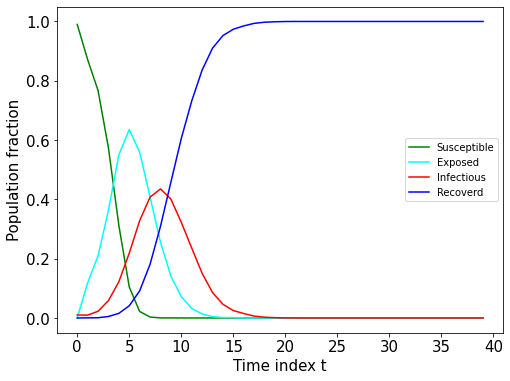

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


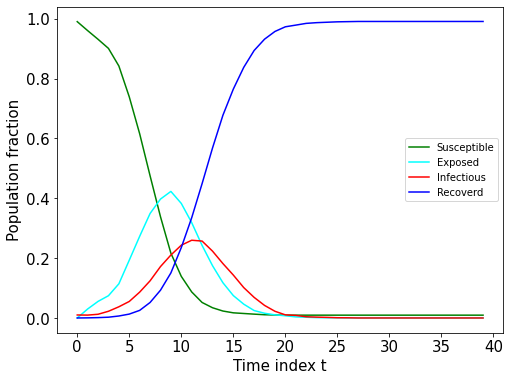

In [13]:
# get the traditional seir result and save it
Gc_1=G1.copy()
Gc_2=G3.copy()
#G_i=Gi.copy()

import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
def model_generator(Graph,fraction,infect_p):
    model = ep.SEIRctModel(Graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infect_p) #the probability of S to E
    cfg.add_model_parameter('gamma', 1/21) #the Latent period of I to R (21)
    cfg.add_model_parameter('alpha', 1/7) # the Latent period of E to I   (7 time steps)
    cfg.add_model_parameter("fraction_infected", fraction)
    # Setting node parameters
    model.set_initial_status(cfg)
    return model


model_c1_n=model_generator(Gc_1,0.01,0.06)
model_c2_n=model_generator(Gc_2,0.01,0.06)


simulator_c1_n=SEIR_Simulation(model_c1_n,dynamic=True)
simulator_c2_n=SEIR_Simulation(model_c2_n,dynamic=True)
result_c1_n=simulator_c1_n.iterations(40)
result_c2_n=simulator_c2_n.iterations(40)

simulator_c1_n.population_plot_percentage_saving(result_c1_n,".//up_eps_figures//Figure 3a.eps")

simulator_c2_n.population_plot_percentage_saving(result_c2_n,".//up_eps_figures//Figure 3b.eps")


In [27]:
simulator2.saving_result(result2,name="HO_P_influence_result_up")
simulator1.saving_result(result1,name="LO_P_influence_result_up")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [26:23<00:00,  7.92s/it]


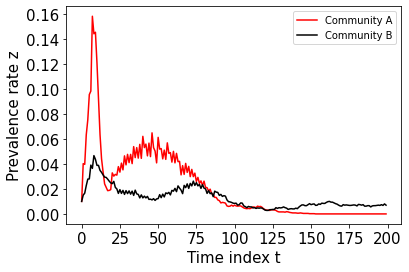

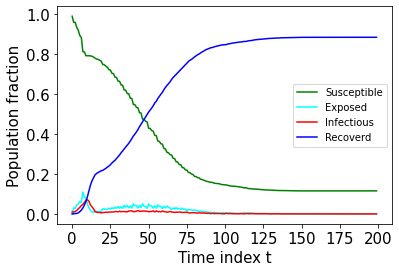

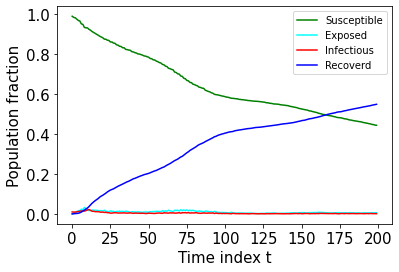

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [29:53<00:00,  8.97s/it]


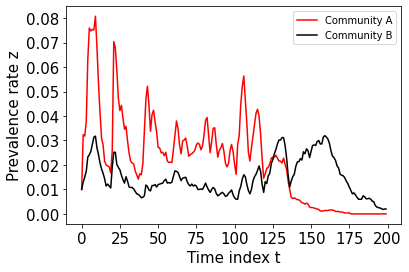

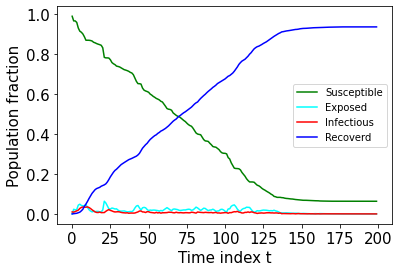

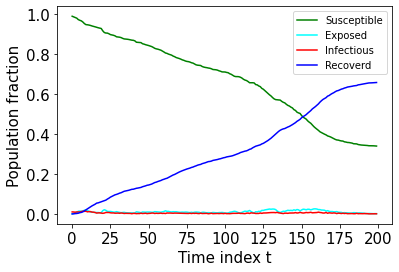

In [9]:
#result for proposed model with risk averse response

Gc1=G1.copy()
Gc2=G3.copy()
G_i=Gi.copy()


import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
def model_generator(Graph,fraction,infect_p):
    model = ep.SEIRctModel(Graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infect_p) #the probability of S to E
    cfg.add_model_parameter('gamma', 1/21) #the Latent period of I to R (21)
    cfg.add_model_parameter('alpha', 1/7) # the Latent period of E to I   (7 time steps)
    cfg.add_model_parameter("fraction_infected", fraction)
    # Setting node parameters
    model.set_initial_status(cfg)
    return model


model_c1=model_generator(Gc1,0.01,0.06)
model_c2=model_generator(Gc2,0.01,0.06)
model_i=model_generator(G_i,0.01,0.06)


model_c1_2=model_generator(Gc1,0.01,0.06)
model_c2_2=model_generator(Gc2,0.01,0.06)
model_i_2=model_generator(G_i,0.01,0.06)
model_c1_2.status=model_c1.status
model_c2_2.status=model_c2.status
model_i_2.status=model_i.status
  
    
def npolicy(p):    
    if p>0.1:

        return 0.8
    elif p>=0.05:

        return 0.5

    elif p>0.03:

        return 0.3   
    else:

        return 0.0

simulator1=SEIR_influence_Simulation(model_c1,model_c2,model_i,immediate_cost=0.1,order=1,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=2,imitation_rate=0.2,cautious_population=0.5,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True)



result1=simulator1.iterations(200)
simulator1.prevalence_plot(result1)
simulator1.population_plot_percentage(result1)


# immediate_cost=0.1,accumulate_factor=0.9,scaling_fator=3,cautious_population=2,rational_rate=9999,policy=None    
simulator2=SEIR_influence_Simulation(model_c1_2,model_c2_2,model_i_2,immediate_cost=0.1,order=3,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=2,imitation_rate=0.2,cautious_population=0.5,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True)

result2=simulator2.iterations(200)
simulator2.prevalence_plot(result2)
simulator2.population_plot_percentage(result2)
simulator2.saving_result(result2,name="HO_P_influence_result")
simulator1.saving_result(result1,name="LO_P_influence_result")

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [16:46<00:00,  7.19s/it]


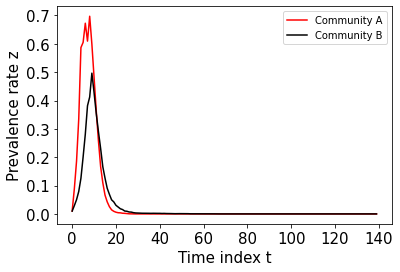

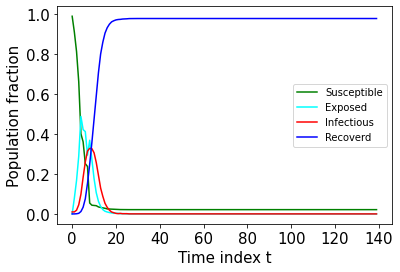

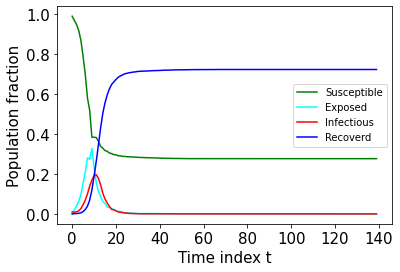

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [18:47<00:00,  8.06s/it]


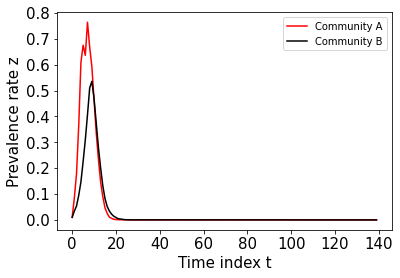

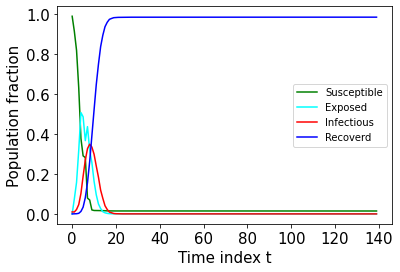

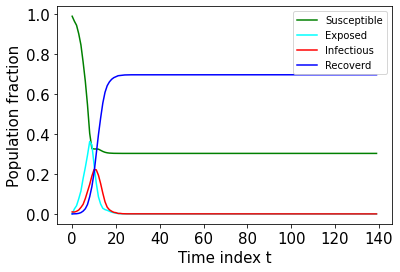

In [29]:
#result for proposed model with risk taking response

Gc1=G1.copy()
Gc2=G3.copy()
G_i=Gi.copy()


import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
def model_generator(Graph,fraction,infect_p):
    model = ep.SEIRctModel(Graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infect_p) #the probability of S to E
    cfg.add_model_parameter('gamma', 1/21) #the Latent period of I to R (21)
    cfg.add_model_parameter('alpha', 1/7) # the Latent period of E to I   (7 time steps)
    cfg.add_model_parameter("fraction_infected", fraction)
    # Setting node parameters
    model.set_initial_status(cfg)
    return model


model_c1=model_generator(Gc1,0.01,0.06)
model_c2=model_generator(Gc2,0.01,0.06)
model_i=model_generator(G_i,0.01,0.06)


model_c1_2=model_generator(Gc1,0.01,0.06)
model_c2_2=model_generator(Gc2,0.01,0.06)
model_i_2=model_generator(G_i,0.01,0.06)
model_c1_2.status=model_c1.status
model_c2_2.status=model_c2.status
model_i_2.status=model_i.status
  
    
def npolicy(p):    
    if p>0.1:

        return 0.8
    elif p>=0.05:

        return 0.5

    elif p>0.03:

        return 0.3   
    else:

        return 0.0

simulator1=SEIR_influence_Simulation(model_c1,model_c2,model_i,immediate_cost=0.1,order=1,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=0.5,imitation_rate=0.2,cautious_population=4,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True)



result1=simulator1.iterations(140)
simulator1.prevalence_plot(result1)
simulator1.population_plot_percentage(result1)


# immediate_cost=0.1,accumulate_factor=0.9,scaling_fator=3,cautious_population=2,rational_rate=9999,policy=None    
simulator2=SEIR_influence_Simulation(model_c1_2,model_c2_2,model_i_2,immediate_cost=0.1,order=3,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=0.5,imitation_rate=0.2,cautious_population=4,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True)

result2=simulator2.iterations(140)
simulator2.prevalence_plot(result2)
simulator2.population_plot_percentage(result2)
simulator2.saving_result(result2,name="HO_N_influence_result_up")
simulator1.saving_result(result1,name="LO_N_influence_result_up")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [41:37<00:00, 12.49s/it]


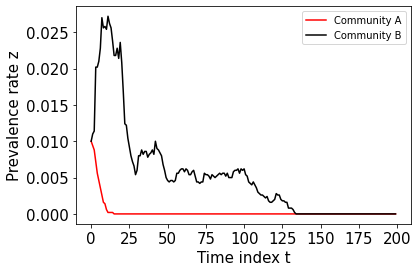

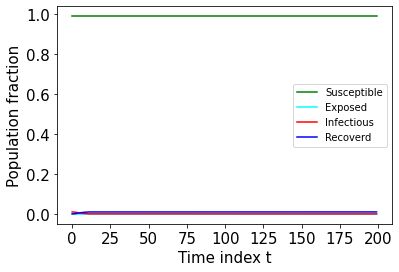

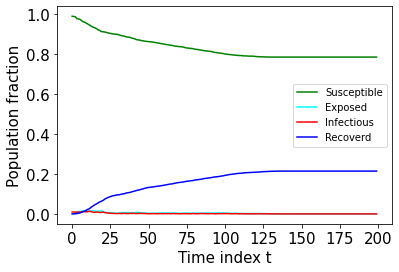

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [38:36<00:00, 11.58s/it]


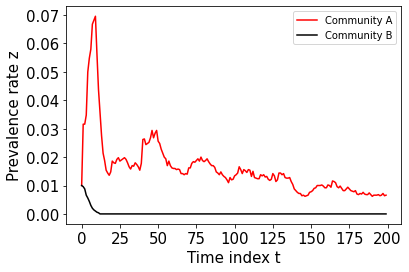

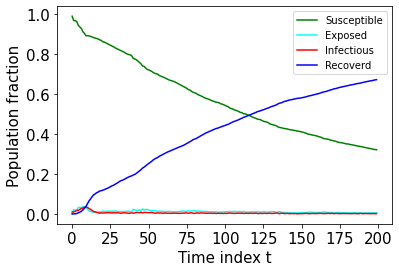

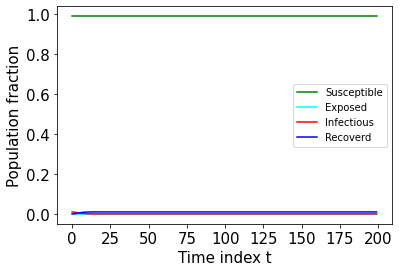

In [34]:
#strict control policy p=1.0 for different community

Gc1=G1.copy()
Gc2=G3.copy()
G_i=Gi.copy()


import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
def model_generator(Graph,fraction,infect_p):
    model = ep.SEIRctModel(Graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infect_p) #the probability of S to E
    cfg.add_model_parameter('gamma', 1/21) #the Latent period of I to R (21)
    cfg.add_model_parameter('alpha', 1/7) # the Latent period of E to I   (7 time steps)
    cfg.add_model_parameter("fraction_infected", fraction)
    # Setting node parameters
    model.set_initial_status(cfg)
    return model


model_c1=model_generator(Gc1,0.01,0.06)
model_c2=model_generator(Gc2,0.01,0.06)
model_i=model_generator(G_i,0.01,0.06)


model_c1_2=model_generator(Gc1,0.01,0.06)
model_c2_2=model_generator(Gc2,0.01,0.06)
model_i_2=model_generator(G_i,0.01,0.06)
model_c1_2.status=model_c1.status
model_c2_2.status=model_c2.status
model_i_2.status=model_i.status
  
    
def npolicy(p):    
    if p>0.1:

        return 0.8
    elif p>=0.05:

        return 0.5

    elif p>0.03:

        return 0.3   
    else:

        return 0.0

simulator1=SEIR_influence_control_Simulation(model_c1,model_c2,model_i,immediate_cost=0.1,order=3,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=2,imitation_rate=0.2,cautious_population=0.5,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True,control_1=True,control_2=False,control_p=1)



result1=simulator1.iterations(200)
simulator1.prevalence_plot(result1)
simulator1.population_plot_percentage(result1)


# immediate_cost=0.1,accumulate_factor=0.9,scaling_fator=3,cautious_population=2,rational_rate=9999,policy=None    
simulator2=SEIR_influence_control_Simulation(model_c1_2,model_c2_2,model_i_2,immediate_cost=0.1,order=3,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=2,imitation_rate=0.2,cautious_population=0.5,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True,control_1=False,control_2=True,control_p=1)

result2=simulator2.iterations(200)
simulator2.prevalence_plot(result2)
simulator2.population_plot_percentage(result2)
simulator2.saving_result(result2,name="Control_c2_influence_result_P_1.0")
simulator1.saving_result(result1,name="Control_c1_influence_result_P_1.0")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [33:02<00:00,  9.91s/it]


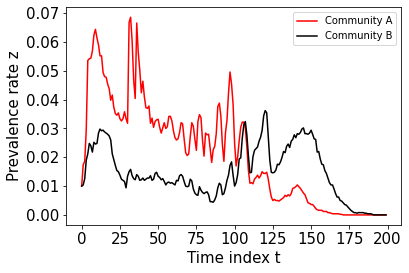

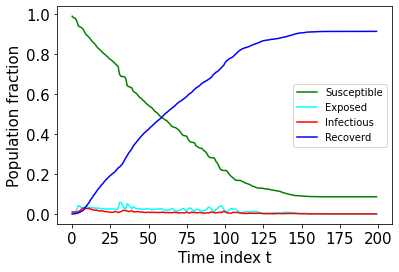

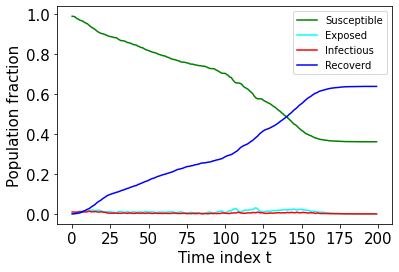

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [32:35<00:00,  9.78s/it]


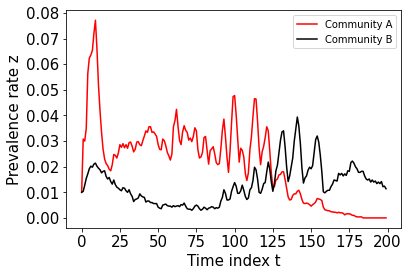

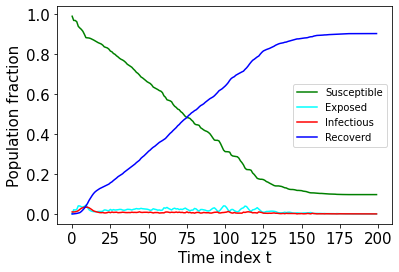

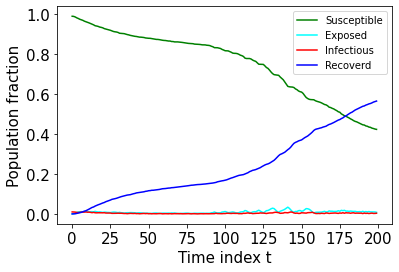

In [35]:
##week control policy p=0.1
## only the susceptible consider BQ
Gc1=G1.copy()
Gc2=G3.copy()
G_i=Gi.copy()


import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
def model_generator(Graph,fraction,infect_p):
    model = ep.SEIRctModel(Graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infect_p) #the probability of S to E
    cfg.add_model_parameter('gamma', 1/21) #the Latent period of I to R (21)
    cfg.add_model_parameter('alpha', 1/7) # the Latent period of E to I   (7 time steps)
    cfg.add_model_parameter("fraction_infected", fraction)
    # Setting node parameters
    model.set_initial_status(cfg)
    return model


model_c1=model_generator(Gc1,0.01,0.06)
model_c2=model_generator(Gc2,0.01,0.06)
model_i=model_generator(G_i,0.01,0.06)


model_c1_2=model_generator(Gc1,0.01,0.06)
model_c2_2=model_generator(Gc2,0.01,0.06)
model_i_2=model_generator(G_i,0.01,0.06)
model_c1_2.status=model_c1.status
model_c2_2.status=model_c2.status
model_i_2.status=model_i.status
  
    
def npolicy(p):    
    if p>0.1:

        return 0.8
    elif p>=0.05:

        return 0.5

    elif p>0.03:

        return 0.3   
    else:

        return 0.0

simulator1=SEIR_influence_control_Simulation(model_c1,model_c2,model_i,immediate_cost=0.1,order=3,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=2,imitation_rate=0.2,cautious_population=0.5,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True,control_1=True,control_2=False,control_p=0.1)



result1=simulator1.iterations(200)
simulator1.prevalence_plot(result1)
simulator1.population_plot_percentage(result1)


# immediate_cost=0.1,accumulate_factor=0.9,scaling_fator=3,cautious_population=2,rational_rate=9999,policy=None    
simulator2=SEIR_influence_control_Simulation(model_c1_2,model_c2_2,model_i_2,immediate_cost=0.1,order=3,comply=50,cost_scaling=0.7
                                     ,accumulate_factor=0.4,scaling_fator=2,imitation_rate=0.2,cautious_population=0.5,rational_rate=10,
                                     policy=npolicy,lock_time=10,p_c1=10,p_c2=10,dynamic=True,control_1=False,control_2=True,control_p=0.1)

result2=simulator2.iterations(200)
simulator2.prevalence_plot(result2)
simulator2.population_plot_percentage(result2)
simulator2.saving_result(result2,name="Control_c2_influence_result_P_0.1")
simulator1.saving_result(result1,name="Control_c1_influence_result_P_0.1")